# Data Prep and Exploratory Analysis
* To succecfully run this notebook you need a python3.7 kernel with requirements in requirements.txt

## This notebook will help you to do:
* Import raw data
* Feature Engineering
* Univariate Analysis
* Save final dataset with the selected features to CSV

# 1. Parameters

In [1]:
#Name
ModelName = 'hr_analytics'

#Setting the VarId and VarDate parameters
#Setting the model target variable name
VarId = 'employee_id'
VarDate = 'reference_date'

#process outputs such as MOJO model, images and performance of tested models
OutputPath = './output_model/'

#If you have a huge dataset, I should consider use a small sample for first execution
PctSampleSize = 1

In [2]:
# !pip -q install -r requirements.txt

In [3]:
import json
import pandas as pd
import numpy as np
import boto3
import sweetviz as sv
from io import StringIO
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
warnings.filterwarnings("ignore", category=FutureWarning)

# 2. Import raw data from CSV

In [4]:
dataprep_df_full = pd.read_csv('./HR_Analytics/train_LZdllcl.csv')
dataprep_df_full

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


In [5]:
#Na base do HR_Analytics não tem a variável de Data de Referencia, mas vamos criar essa variável apenas para mostrar como o código funciona com uma base que tem Safra 
random.seed(1)
for i in range(len(dataprep_df_full)):
    dataprep_df_full.loc[i, (VarDate)] = random.choice(['2022-01','2022-02','2022-03', '2022-04', '2022-05'])

In [6]:
#Work with a sample data if the PctSampleSize is less than 1
if PctSampleSize == 1:
    dataprep_df = dataprep_df_full.copy()
else:
    dataprep_df = dataprep_df_full.sample(frac=PctSampleSize, replace=False, random_state=1)

## 2.1 Define the data time period for used to traing de model

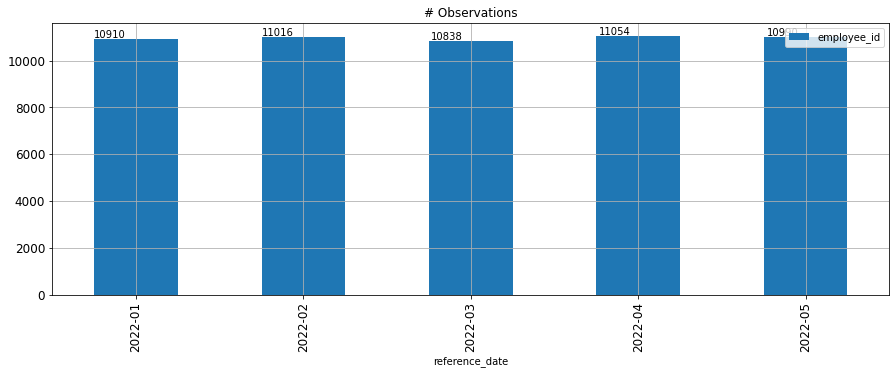

In [7]:
dataprep_target = dataprep_df[[VarDate, VarId]].groupby(VarDate).agg({VarId:'count'})
ax = dataprep_target[VarId].plot(secondary_y=False, kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=("# Observations"))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# 3. Feature Engineering

In [8]:
dataprep_df = dataprep_df.rename(columns={"KPIs_met >80%": "kpis_met_80"})

## 3.1 Treatment of Numeric Missing Data

In [9]:
#Create the "Missing" category for missing values in string vaviables
dataprep_df = dataprep_df.apply(lambda x: x.fillna(0) if x.dtype.kind in 'biufc' else x.fillna('Missing'))

# 4. Univariate Analysis

## 4.1 EDA with Sweetviz


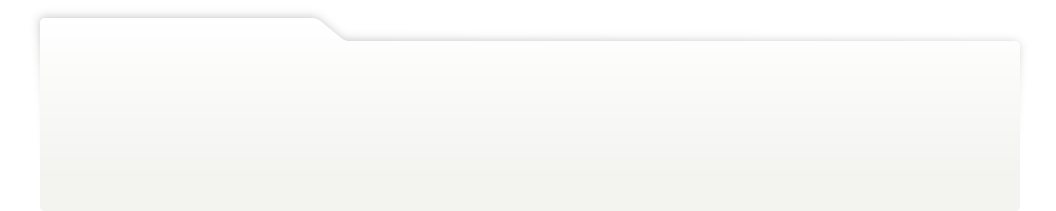
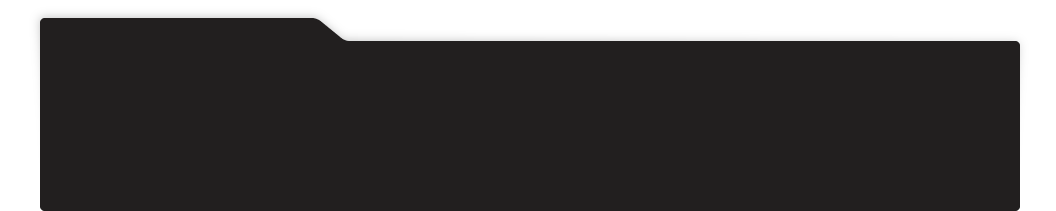
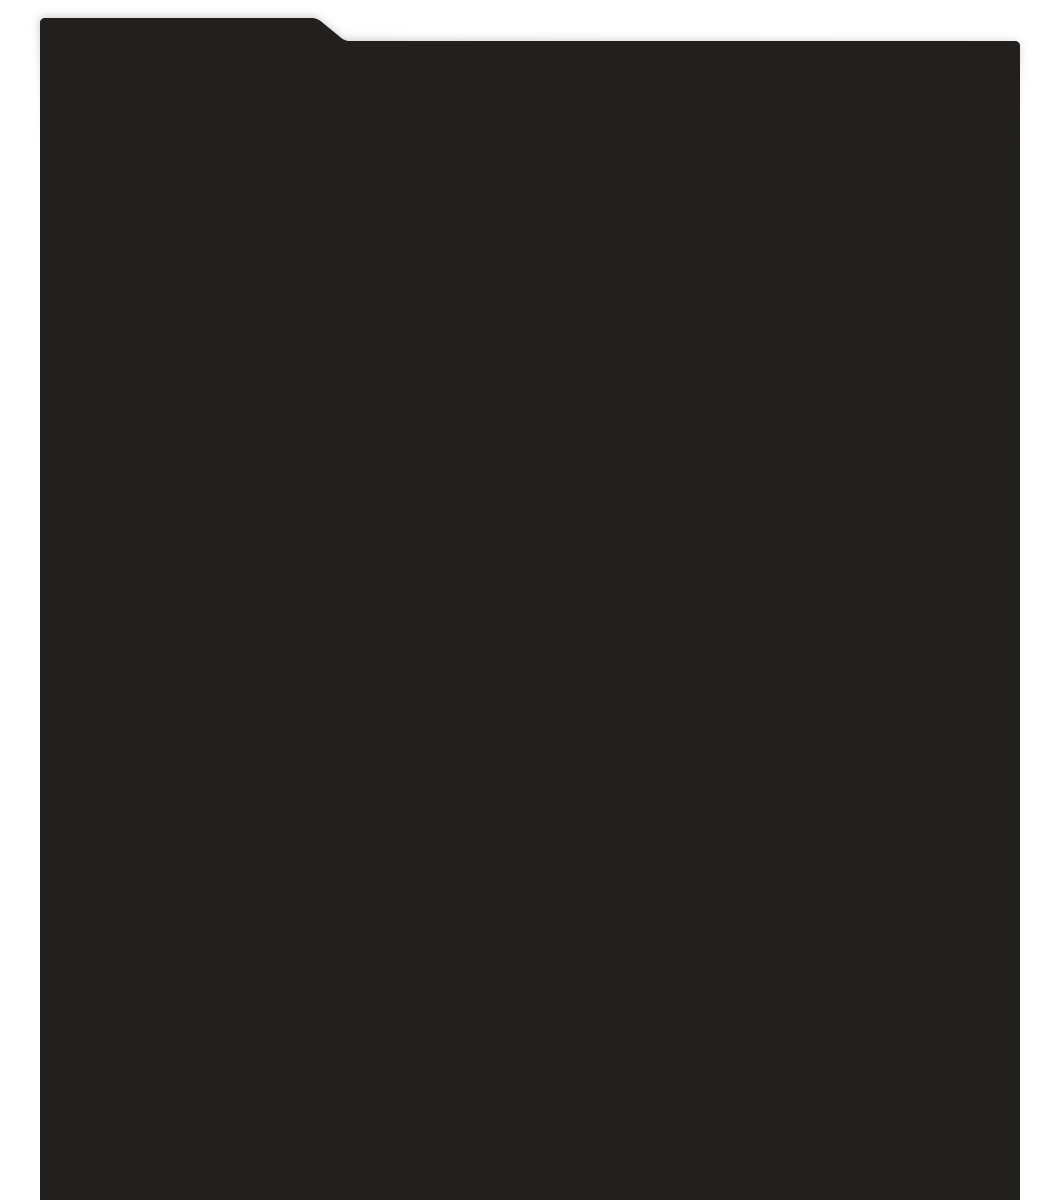
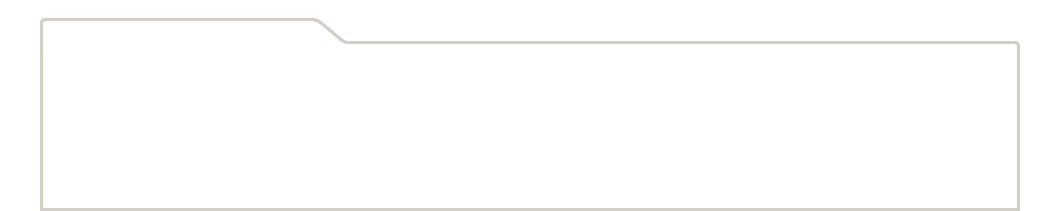
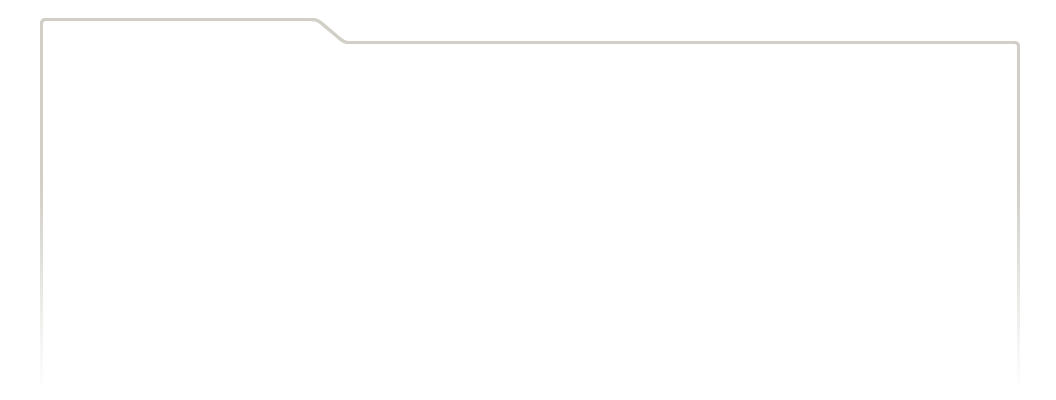
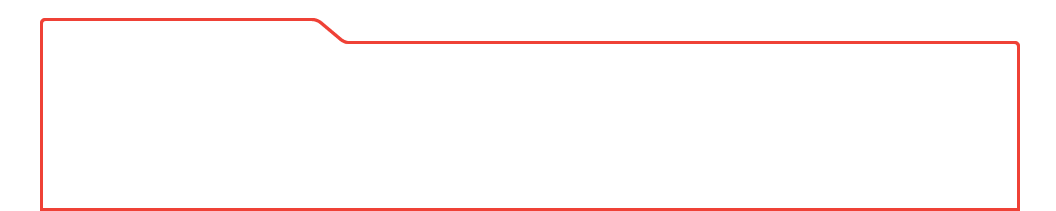
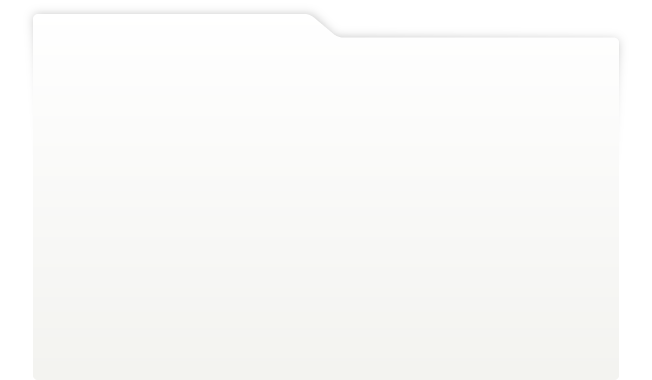
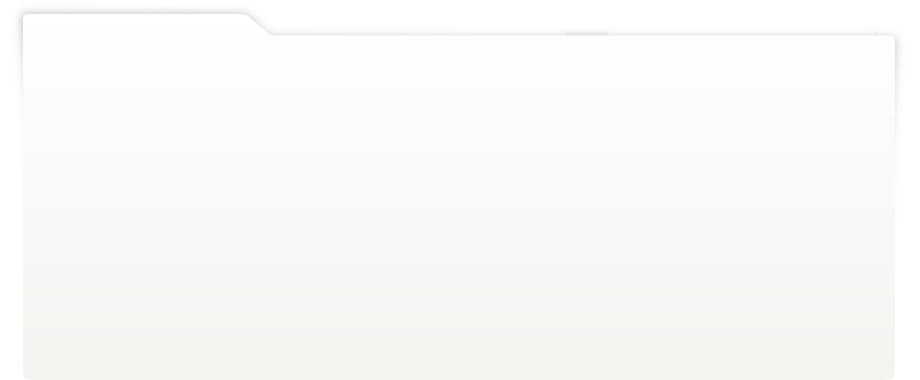
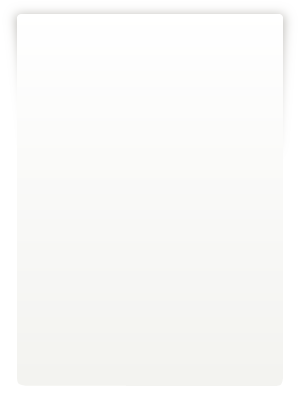
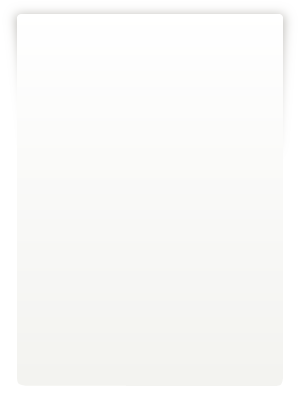
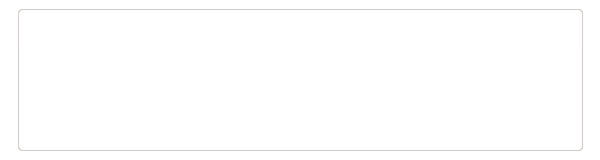
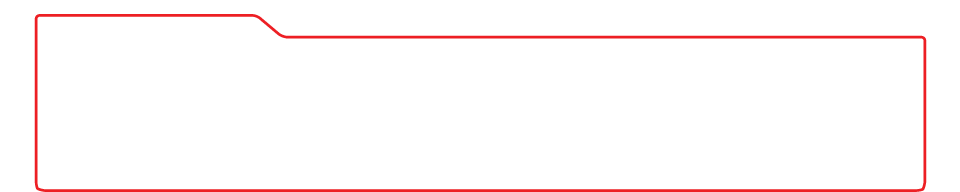
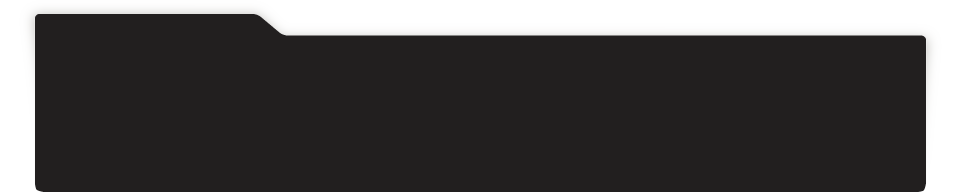
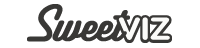
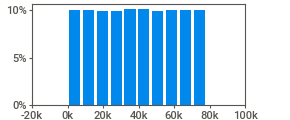
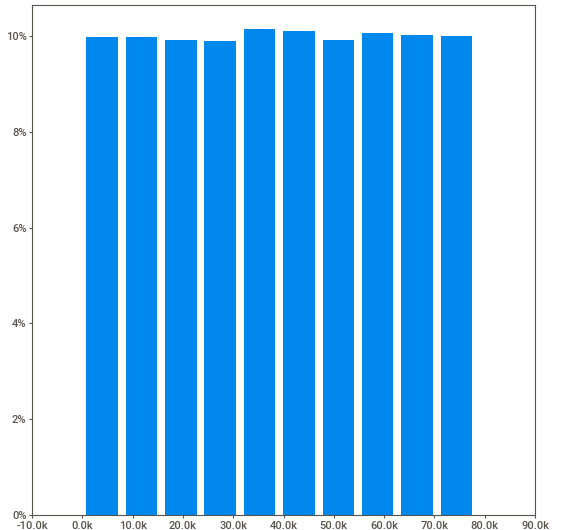
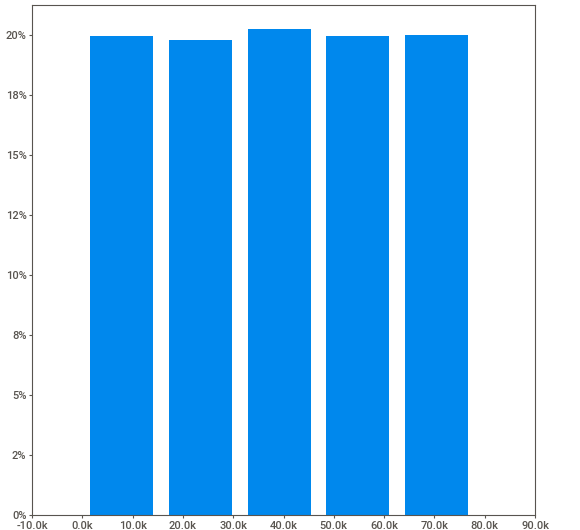
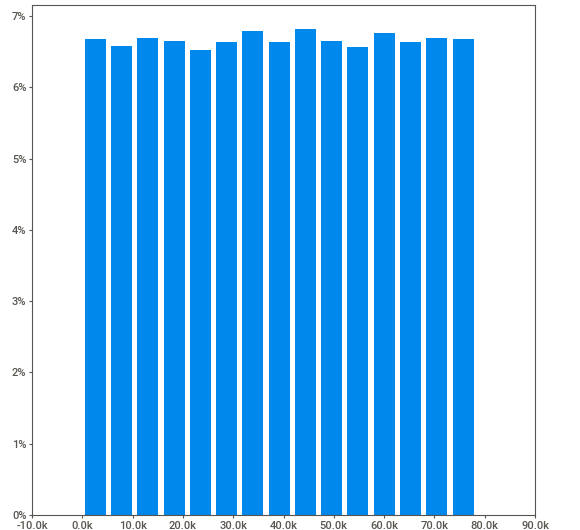
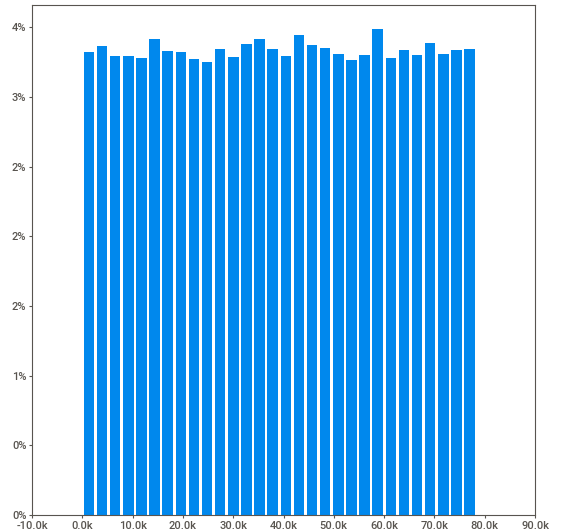
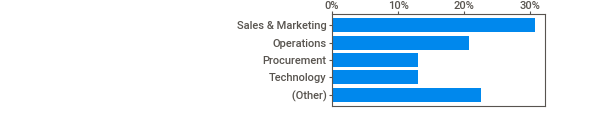
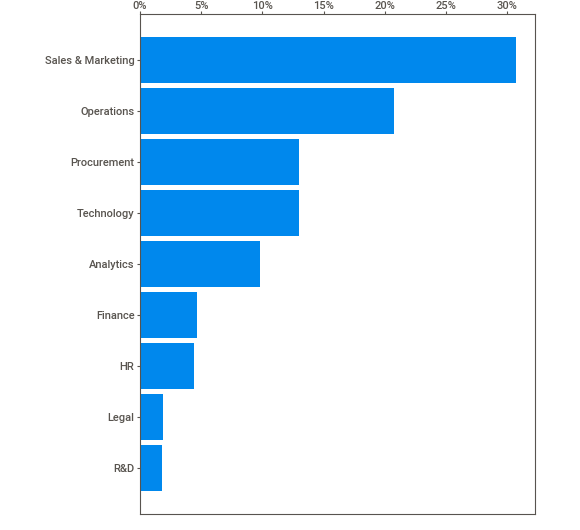
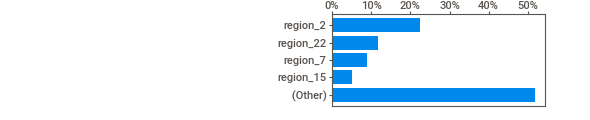
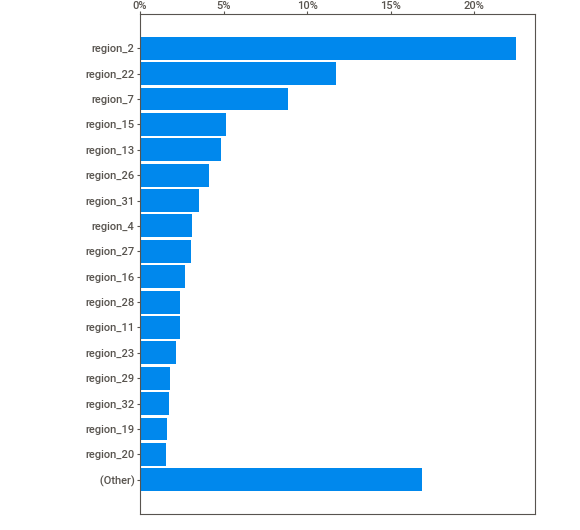
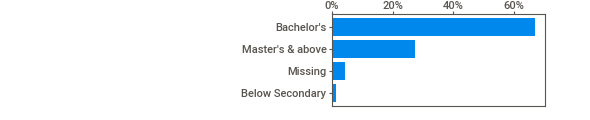
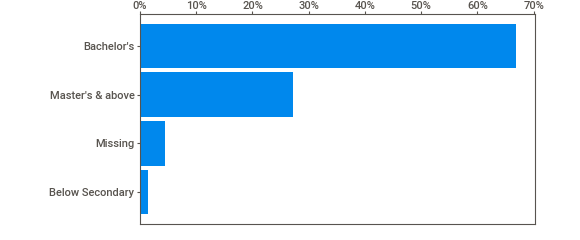
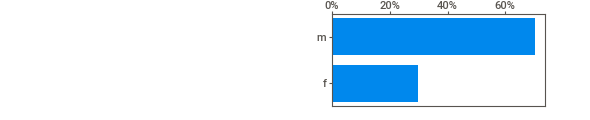
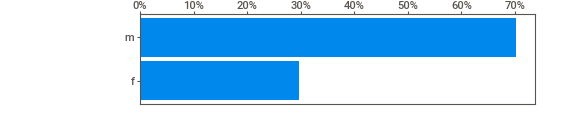
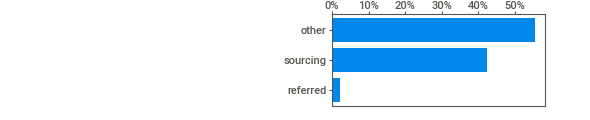
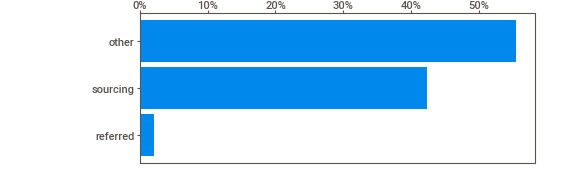
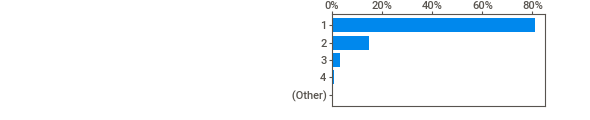
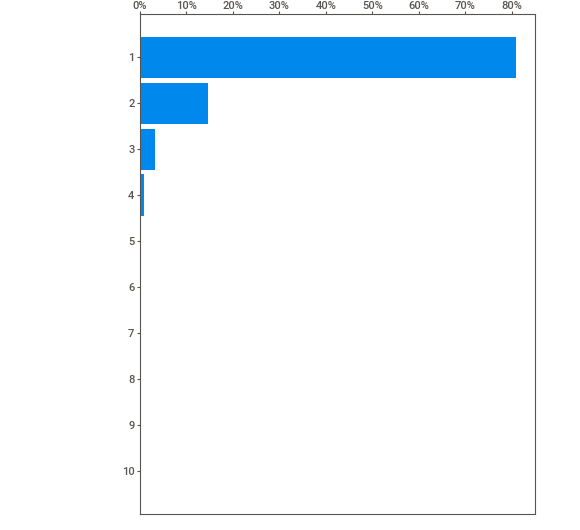
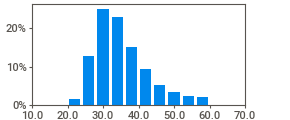
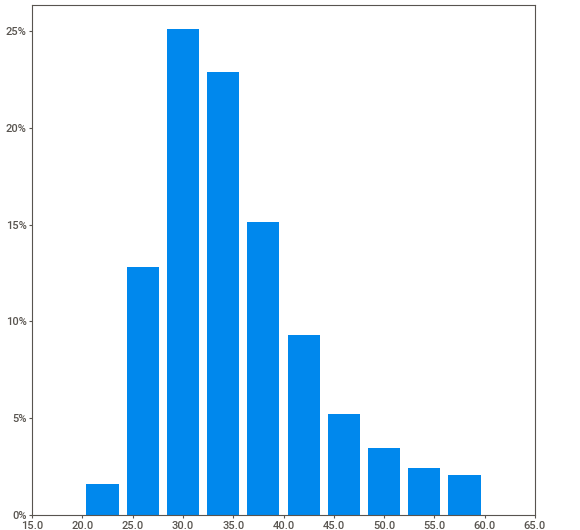
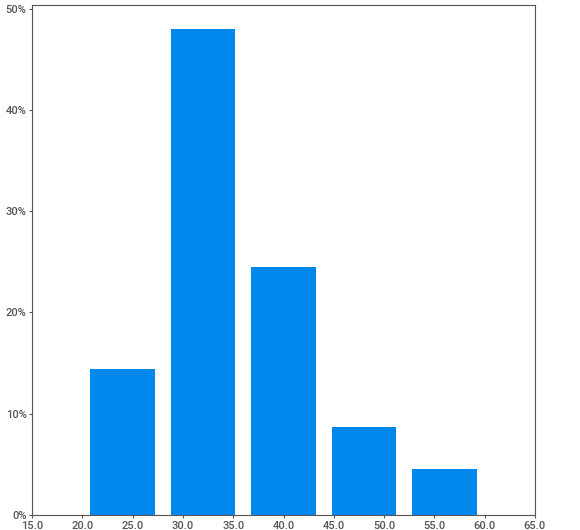
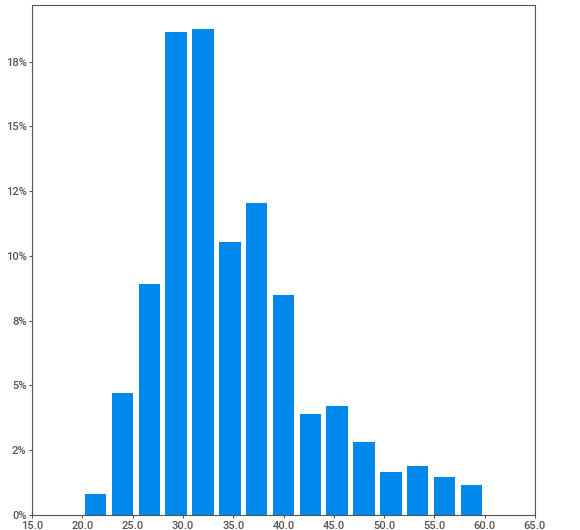
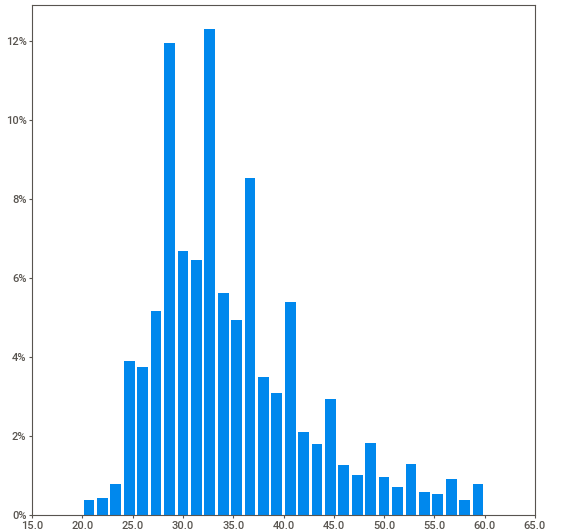
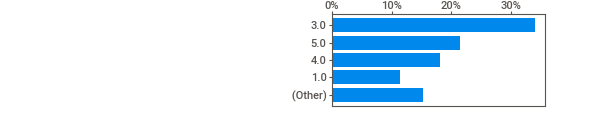
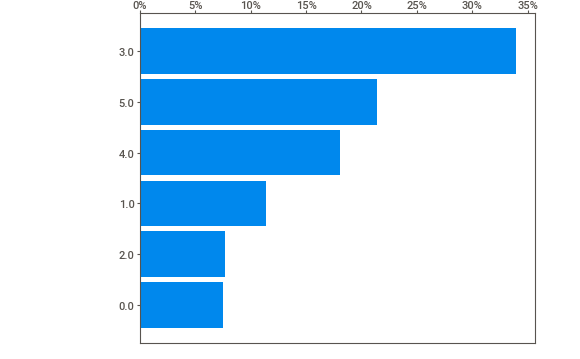
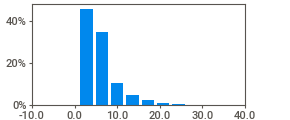
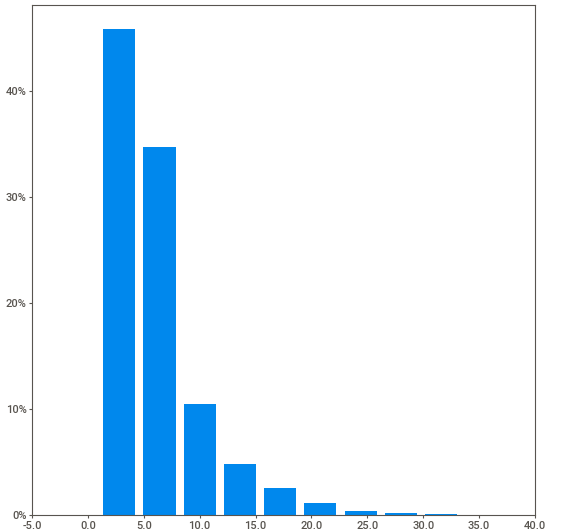
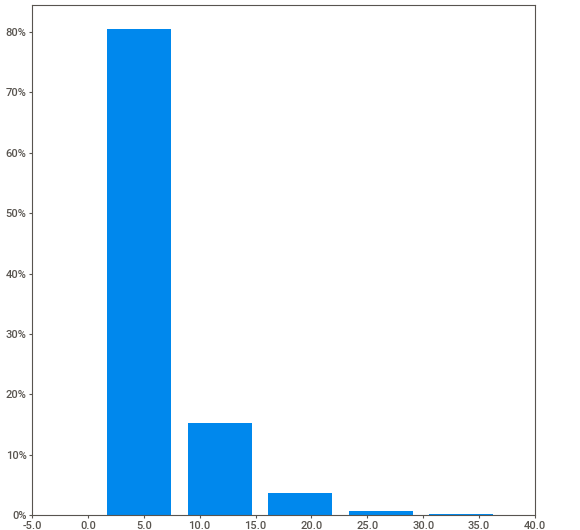
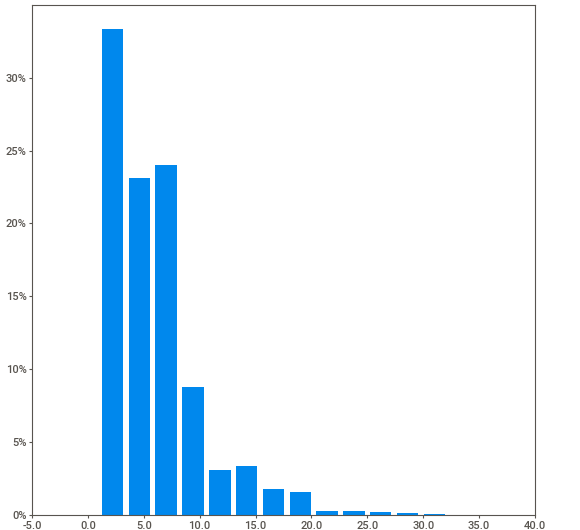
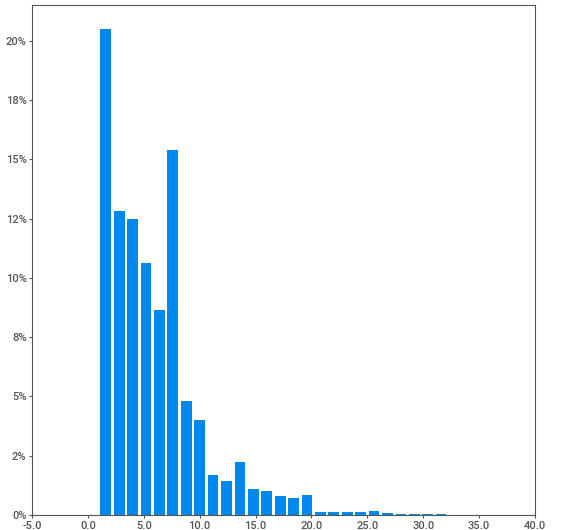
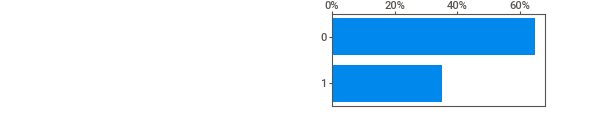
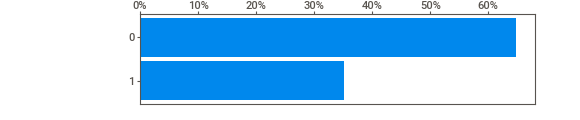
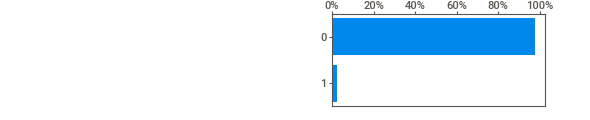
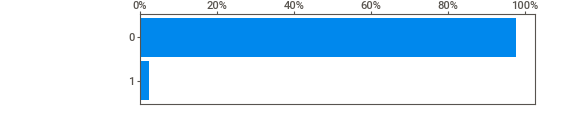
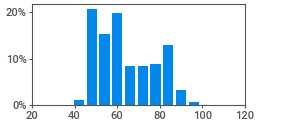
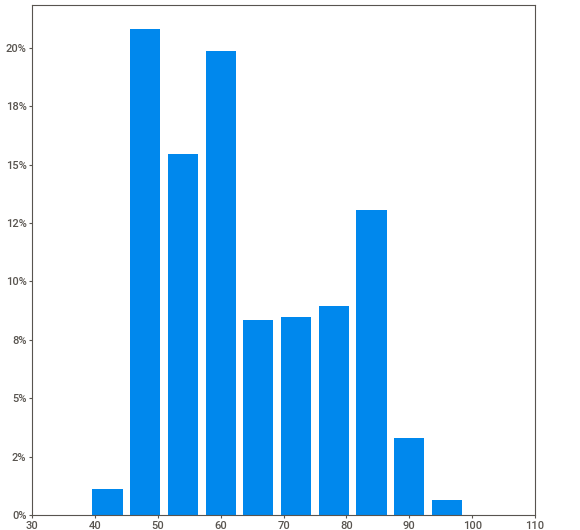
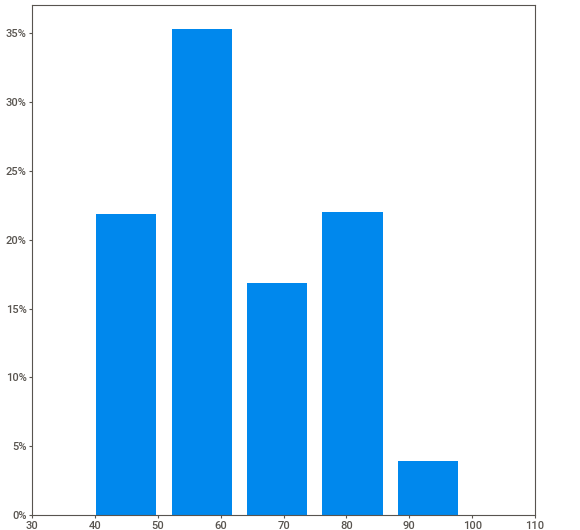
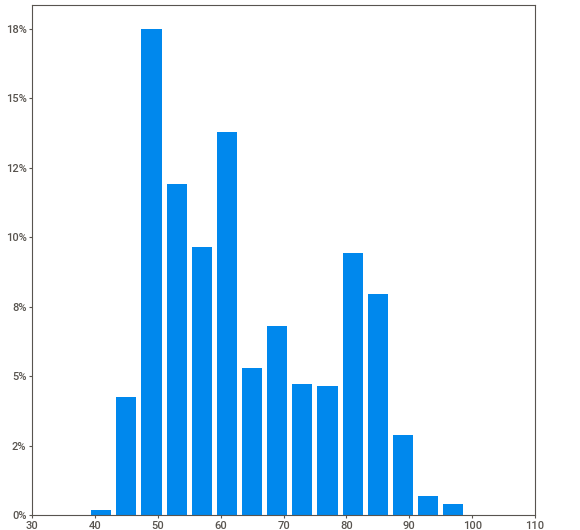
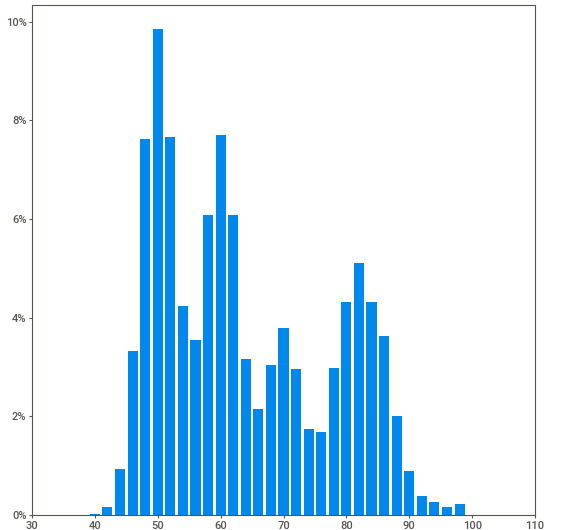
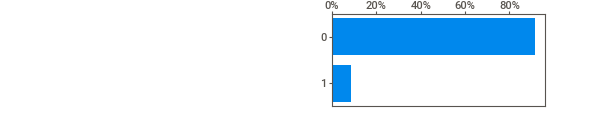
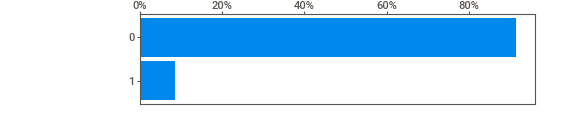
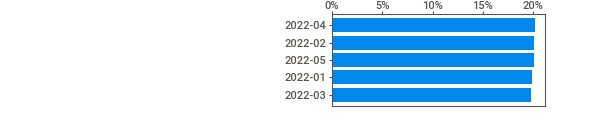
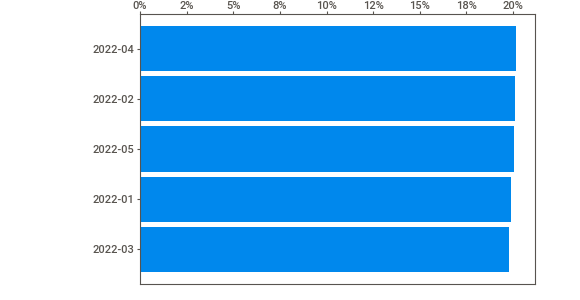
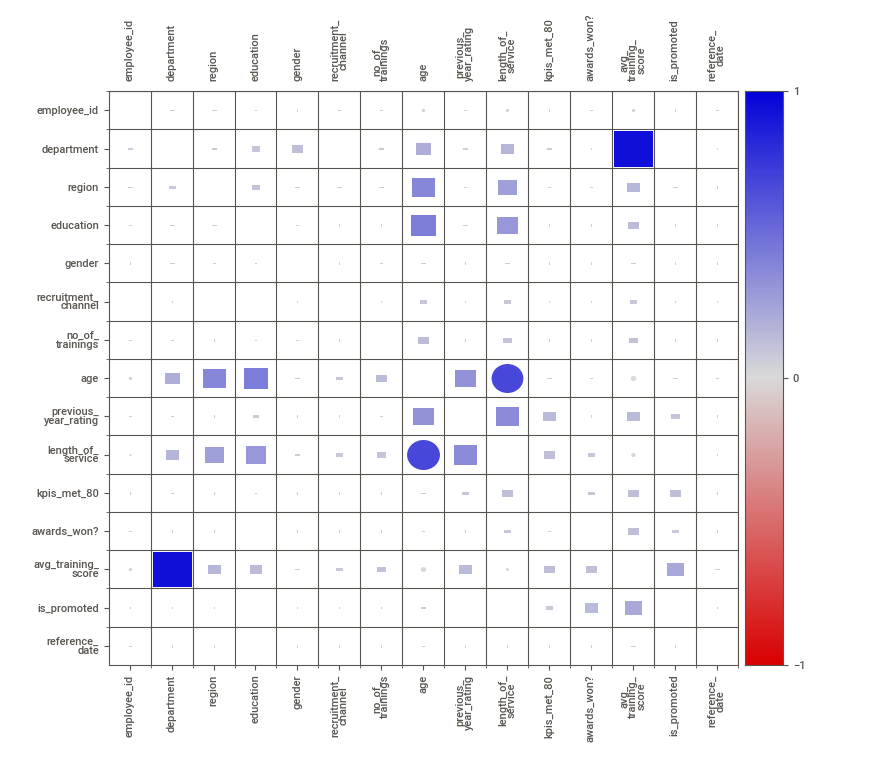
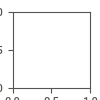

In [10]:
analysis = sv.analyze(dataprep_df)
analysis.show_notebook()

## 4.2 Classify the types of variables
#### list all columns to select the ones to be used

In [11]:
for i in dataprep_df.columns:
    print(i + ": " + analysis.get_type(i).name)

employee_id: TYPE_NUM
department: TYPE_CAT
region: TYPE_CAT
education: TYPE_CAT
gender: TYPE_CAT
recruitment_channel: TYPE_CAT
no_of_trainings: TYPE_CAT
age: TYPE_NUM
previous_year_rating: TYPE_CAT
length_of_service: TYPE_NUM
kpis_met_80: TYPE_BOOL
awards_won?: TYPE_BOOL
avg_training_score: TYPE_NUM
is_promoted: TYPE_BOOL
reference_date: TYPE_CAT


### From the variables listed above you can select which  one will be tested in the model and confirm if the correct type is numeric(NUM) or categorical (CAT). Paste the correct information below:

In [12]:
#It is necessary to define the types of variables (cageroric and numeric) to ensure that the type of data used in the modeling will be the most suitable.
#For example, categorical variables need to be defined as a string because this prevents it from being treated as a numeric variable in H20 modeling
#Another example is that the string variables will have a missing treatment by placing the missing category for all values found as 'null'
CAT = ['department'
,'region'
,'education'
,'gender'
,'recruitment_channel'
,'kpis_met_80']

#float
#Testar as variaveis no_of_trainings e previous_year_rating como categorcias e ver se melhora o modelo
NUM = ['no_of_trainings'
,'previous_year_rating'       
,'age'
,'length_of_service'
,'avg_training_score'
]
selected_features = CAT + NUM

In [13]:
#Numeric features must be float type
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

#Categorical features must be string
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

## 4.2 Outlier Analysys with Box plot and Violin Plot

In [14]:
def plot_comparison(x, title):
    fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
    fig.suptitle(title, fontsize=16)
    sns.distplot(x.rename(""), ax=ax[0])
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x.rename(""), ax=ax[1])
    ax[1].set_title('Boxplot')
    sns.violinplot(x.rename(""), ax=ax[2])
    ax[2].set_title('Violin plot')
    plt.show()

no_of_trainings


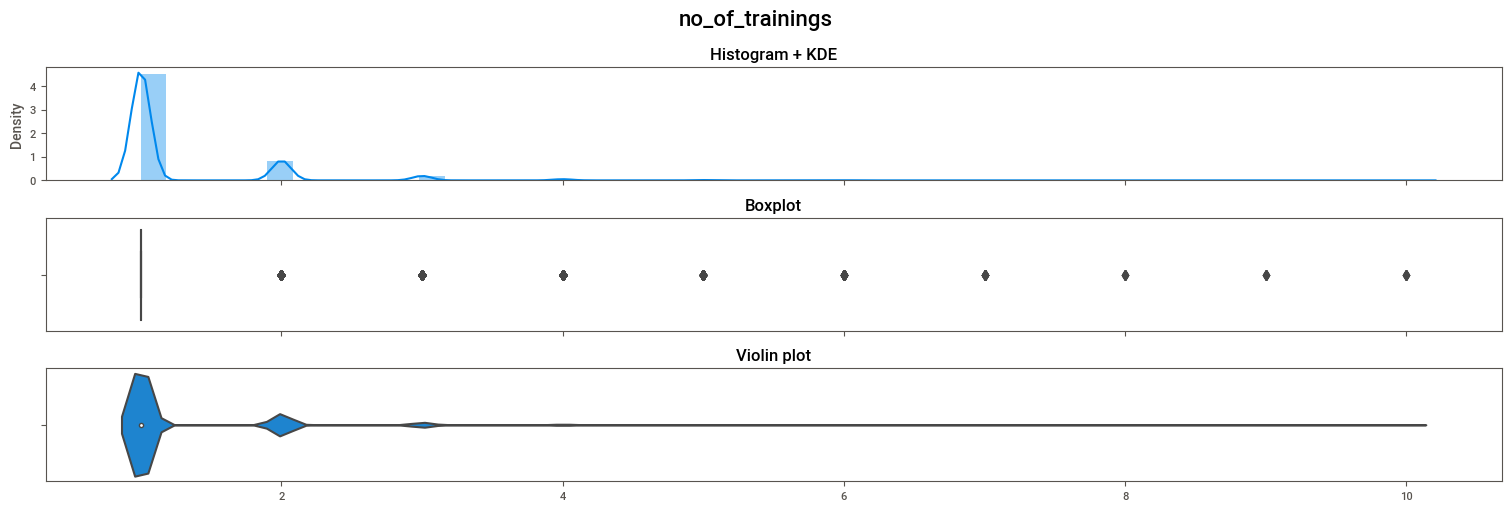

previous_year_rating


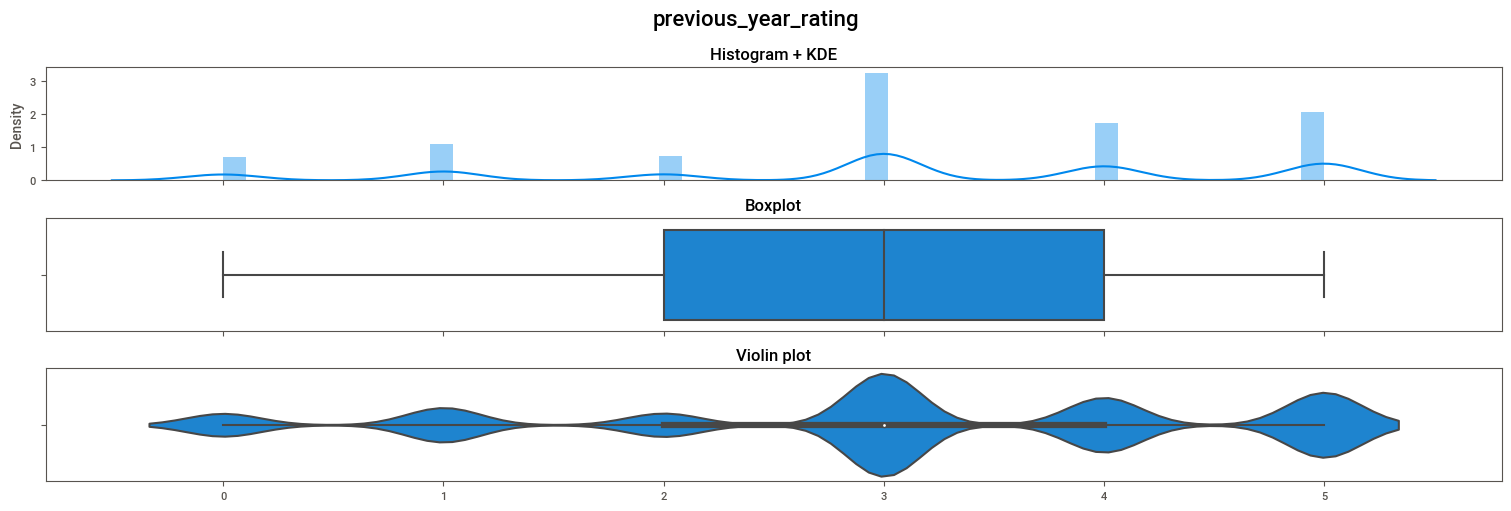

age


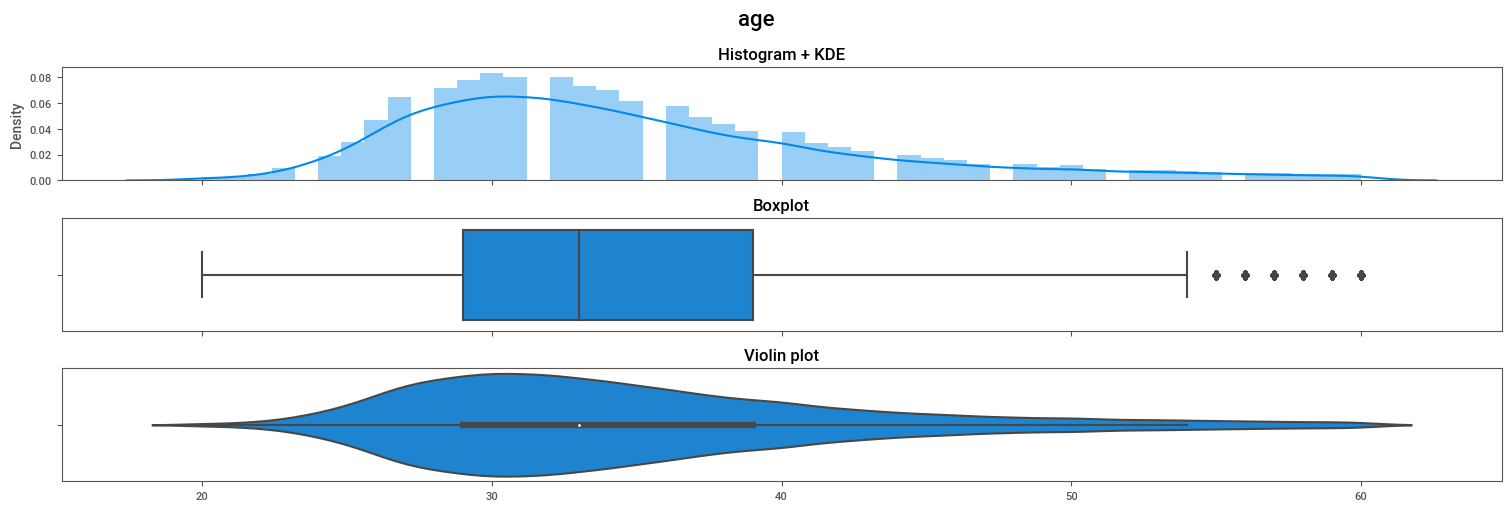

length_of_service


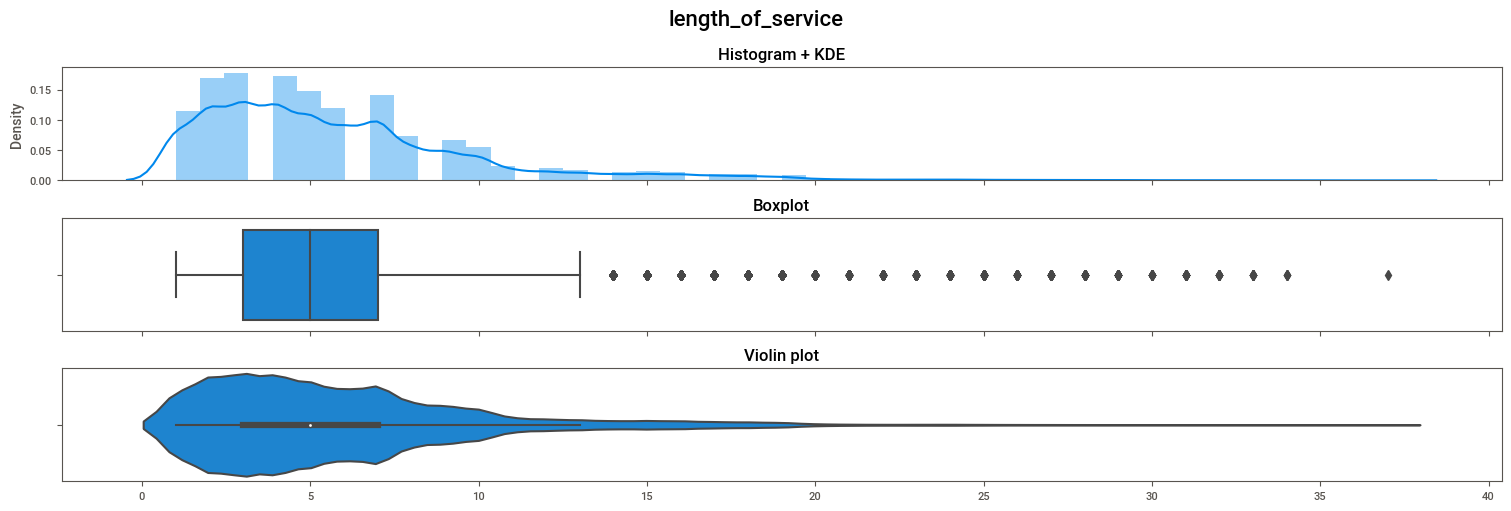

avg_training_score


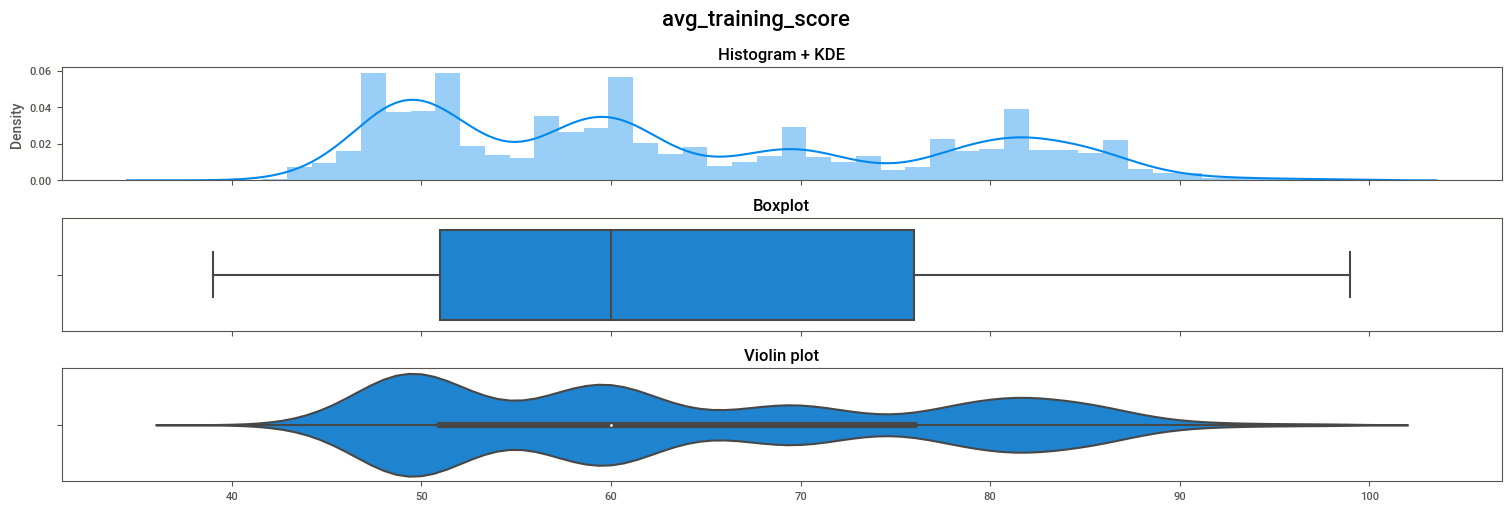

In [15]:
## Distribution analysis of numerical variables
for i in NUM:
    print(i)
    plot_comparison(dataprep_df[i], i)

## 4.3 Outliers Removing

Low: 1.0
High: 4.0
Reduction: -0.36% | 199


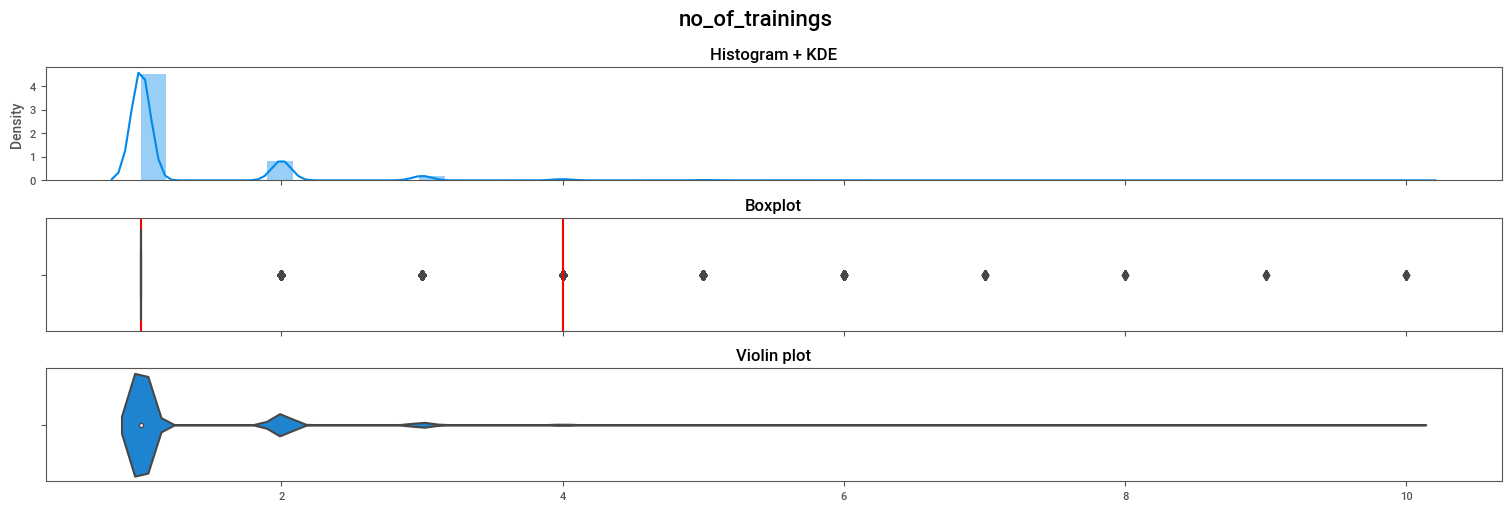

In [16]:
var = 'no_of_trainings'

q_low = dataprep_df[var].quantile(0)
q_hi  = dataprep_df[var].quantile(0.99)
print('Low: ' + str(q_low))
print('High: ' + str(q_hi))
print('Reduction: ' 
      + "{0:.2%}".format(len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])/len(dataprep_df)-1) 
      + " | " 
      + str(len(dataprep_df)-len(dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)])))

def plot_comparison(x, title, low, high):
    fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
    fig.suptitle(title, fontsize=16)
    sns.distplot(x.rename(""), ax=ax[0])
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x.rename(""), ax=ax[1])
    ax[1].set_title('Boxplot')
    sns.violinplot(x.rename(""), ax=ax[2])
    ax[2].set_title('Violin plot')
    # only one line may be specified; full height
    ax[1].axvline(x = low, color = 'red')
    ax[1].axvline(x = high, color = 'red')
    plt.show()
    
plot_comparison(dataprep_df[var], var, q_low, q_hi)

dataprep_df = dataprep_df[(dataprep_df[var] <= q_hi) & (dataprep_df[var] >= q_low)]

# 5. Create Dummies for the categorical variables

In [17]:
#We add the prefix "dummy_" and and droped the first category for every column define in the list CAT
dummies_dataprep_df = pd.concat([dataprep_df, (pd.get_dummies(dataprep_df[CAT], columns=CAT, drop_first=True)).add_prefix("dummy_")], axis=1)

# 6. Normalize the numeric variables between 0 and 1

In [18]:
normalized_dataprep_df = pd.concat([dummies_dataprep_df, ((dataprep_df[NUM]-dataprep_df[NUM].min())/(dataprep_df[NUM].max()-dataprep_df[NUM].min())).add_prefix("normalized_")], axis=1)

# 7. Save final dataset with the selected features to CSV

In [19]:
#Include the new variables
normalized_and_dummy = []
for i in normalized_dataprep_df.columns:
    if (i.startswith('dummy_')) or (i.startswith('normalized_')):
        normalized_and_dummy.append(i)

In [20]:
normalized_dataprep_df.loc[:, (selected_features+[VarId, VarDate]+normalized_and_dummy)].to_csv('./HR_Analytics/dataprep_df.csv', index=False, header=True)